# Test of different models

## Logistic regression

In [6]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données (adaptez le chemin selon votre fichier)
# Exemple pour les données de prévalence COPD
df = pd.read_csv('../exploratory_data_analysis/data/Refined/1721/COPD_prevalence.csv')

# Affichage des premières lignes pour vérifier les noms de colonnes
print("Aperçu des données :")
print(df.head())
print("\nNoms des colonnes :")
print(df.columns.tolist())
print("\nTypes de données :")
print(df.dtypes)

Aperçu des données :
      Measure Country Name                                Disease Metric  \
0  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
1  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
2  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
3  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
4  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   

   Year        Value Country Code  \
0  2015  1588.006576          IDN   
1  2015  1588.006576          IDN   
2  2015  1588.006576          IDN   
3  2017  1646.266156          IDN   
4  2018  1680.660819          IDN   

  Access to clean fuels and technologies for cooking (% of population)  \
0                                               67.3                     
1                                               67.3                     
2                                               67.3                     
3  

In [7]:
# Étape 1 : Tri des données par Location et Period
# Assurez-vous d'adapter les noms de colonnes selon votre DataFrame
# (Location ou Country, Period ou Year)

# Supposons que les colonnes sont 'Location' et 'Period'
# Si vos colonnes ont d'autres noms, modifiez-les ici
location_col = 'Country Name'  # ou 'Country'
period_col = 'Year'      # ou 'Year'
value_col = 'Value'        # Colonne contenant le taux

# Vérifier que les colonnes existent
if location_col not in df.columns or period_col not in df.columns or value_col not in df.columns:
    print("⚠️ Attention : Veuillez vérifier les noms de colonnes !")
    print(f"Colonnes disponibles : {df.columns.tolist()}")
else:
    # Tri des données
    df = df.sort_values([location_col, period_col]).reset_index(drop=True)
    print(f"✓ Données triées par {location_col} puis {period_col}")
    print(f"Nombre de lignes : {len(df)}")
    print(f"Nombre de pays/régions : {df[location_col].nunique()}")
    print(f"Période : {df[period_col].min()} - {df[period_col].max()}")

✓ Données triées par Country Name puis Year
Nombre de lignes : 1131
Nombre de pays/régions : 47
Période : 2010 - 2021


In [8]:
# Étape 2 : Calcul de la différence par rapport à l'année précédente
# La méthode groupby().diff() calcule automatiquement la différence
# avec la ligne précédente au sein de chaque groupe

df['value_diff'] = df.groupby(location_col)[value_col].diff()

print("✓ Colonne 'value_diff' créée")
print(f"\nExemple pour un pays (les 10 premières lignes) :")
print(df[[location_col, period_col, value_col, 'value_diff']].head(10))

✓ Colonne 'value_diff' créée

Exemple pour un pays (les 10 premières lignes) :
  Country Name  Year        Value  value_diff
0      Albania  2015  3263.566286         NaN
1      Albania  2016  3415.349428  151.783142
2      Albania  2017  3561.038801  145.689373
3      Albania  2018  3619.240209   58.201408
4      Albania  2019  3732.947927  113.707717
5      Albania  2020  3946.051306  213.103380
6    Australia  2012  3367.843421         NaN
7    Australia  2013  3353.098308  -14.745113
8    Australia  2013  3353.098308    0.000000
9    Australia  2013  3353.098308    0.000000


In [9]:
# Étape 3 : Création de la variable cible Y (CLASSIFICATION MULTI-CLASSE)
# Définition du seuil de stagnation
threshold = 0.0  # Ajustez ce seuil selon vos besoins (ex: 0.0, 0.001, 0.01, etc.)

print("="*80)
print("CRÉATION DE LA VARIABLE CIBLE Y - CLASSIFICATION MULTI-CLASSE")
print("="*80)
print(f"\n📊 Seuil de stagnation défini : {threshold}")
print("\nRègles de classification :")
print(f"  - Y = 0 ('Diminue')  si value_diff < -{threshold}")
print(f"  - Y = 1 ('Stagne')   si -{threshold} <= value_diff <= {threshold}")
print(f"  - Y = 2 ('Augmente') si value_diff > {threshold}")

# Création de la variable Y avec 3 classes
def classify_change(diff, threshold=0.0):
    if pd.isna(diff):
        return np.nan
    elif diff < -threshold:
        return 0  # Diminue
    elif diff > threshold:
        return 2  # Augmente
    else:
        return 1  # Stagne

# Application de la fonction de classification
df['Y'] = df['value_diff'].apply(lambda x: classify_change(x, threshold))

# Version avec labels textuels pour la lisibilité
df['Y_label'] = df['Y'].map({
    0: 'Diminue',
    1: 'Stagne',
    2: 'Augmente'
})

print(f"\n✓ Variables cibles 'Y' et 'Y_label' créées")
print(f"   Nombre de valeurs NaN dans Y : {df['Y'].isna().sum()}")
print(f"   Nombre total de lignes : {len(df)}")
print("\n" + "="*80)

CRÉATION DE LA VARIABLE CIBLE Y - CLASSIFICATION MULTI-CLASSE

📊 Seuil de stagnation défini : 0.0

Règles de classification :
  - Y = 0 ('Diminue')  si value_diff < -0.0
  - Y = 1 ('Stagne')   si -0.0 <= value_diff <= 0.0
  - Y = 2 ('Augmente') si value_diff > 0.0

✓ Variables cibles 'Y' et 'Y_label' créées
   Nombre de valeurs NaN dans Y : 47
   Nombre total de lignes : 1131



In [11]:
# Étape 4 : Gestion des valeurs NaN
# Suppression des lignes où Y est NaN (première année de chaque pays)

print("Avant suppression des NaN :")
print(f"  Nombre total de lignes : {len(df)}")
print(f"  Nombre de NaN dans Y : {df['Y'].isna().sum()}")

# Création d'un nouveau DataFrame sans les NaN
df_clean = df.dropna(subset=['Y']).copy()

print("\nAprès suppression des NaN :")
print(f"  Nombre total de lignes : {len(df_clean)}")
print(f"  Nombre de NaN dans Y : {df_clean['Y'].isna().sum()}")

# Conversion de Y en entier
df_clean['Y'] = df_clean['Y'].astype(int)

print("\n✓ Données nettoyées et prêtes pour le Machine Learning (classification multi-classe)")
print("="*80)

Avant suppression des NaN :
  Nombre total de lignes : 1131
  Nombre de NaN dans Y : 47

Après suppression des NaN :
  Nombre total de lignes : 1084
  Nombre de NaN dans Y : 0

✓ Données nettoyées et prêtes pour le Machine Learning (classification multi-classe)


In [13]:
# Étape 5 : Affichage de la distribution de la variable cible Y (3 CLASSES)

print("="*80)
print("DISTRIBUTION DE LA VARIABLE CIBLE Y - CLASSIFICATION MULTI-CLASSE")
print("="*80)

# Comptes absolus
print("\n1. Comptes (value_counts) :")
counts = df_clean['Y'].value_counts().sort_index()
print(counts)

# Pourcentages
print("\n2. Pourcentages :")
distribution_pct = df_clean['Y'].value_counts(normalize=True).sort_index() * 100
for classe, pct in distribution_pct.items():
    label = {0: 'Diminue', 1: 'Stagne', 2: 'Augmente'}[classe]
    print(f"   Classe {classe} ({label:9s}) : {pct:6.2f}%")

# Avec les labels
print("\n3. Distribution avec labels :")
label_counts = df_clean['Y_label'].value_counts()
print(label_counts)

# Statistiques de déséquilibre
print("\n4. Analyse du déséquilibre des classes :")
if len(counts) == 3:
    max_count = counts.max()
    min_count = counts.min()
    ratio = max_count / min_count
    print(f"   Classe la plus fréquente : {counts.idxmax()} ({counts.max()} observations)")
    print(f"   Classe la moins fréquente : {counts.idxmin()} ({counts.min()} observations)")
    print(f"   Ratio de déséquilibre : {ratio:.2f}:1")
    
    if ratio < 2:
        print("   ✓ Classes relativement équilibrées")
    elif ratio < 5:
        print("   ⚠️ Déséquilibre modéré - SMOTE recommandé")
    else:
        print("   ⚠️ Déséquilibre important - SMOTE fortement recommandé")

print("\n" + "="*80)

DISTRIBUTION DE LA VARIABLE CIBLE Y - CLASSIFICATION MULTI-CLASSE

1. Comptes (value_counts) :
Y
0     54
1    778
2    252
Name: count, dtype: int64

2. Pourcentages :
   Classe 0 (Diminue  ) :   4.98%
   Classe 1 (Stagne   ) :  71.77%
   Classe 2 (Augmente ) :  23.25%

3. Distribution avec labels :
Y_label
Stagne      778
Augmente    252
Diminue      54
Name: count, dtype: int64

4. Analyse du déséquilibre des classes :
   Classe la plus fréquente : 1 (778 observations)
   Classe la moins fréquente : 0 (54 observations)
   Ratio de déséquilibre : 14.41:1
   ⚠️ Déséquilibre important - SMOTE fortement recommandé



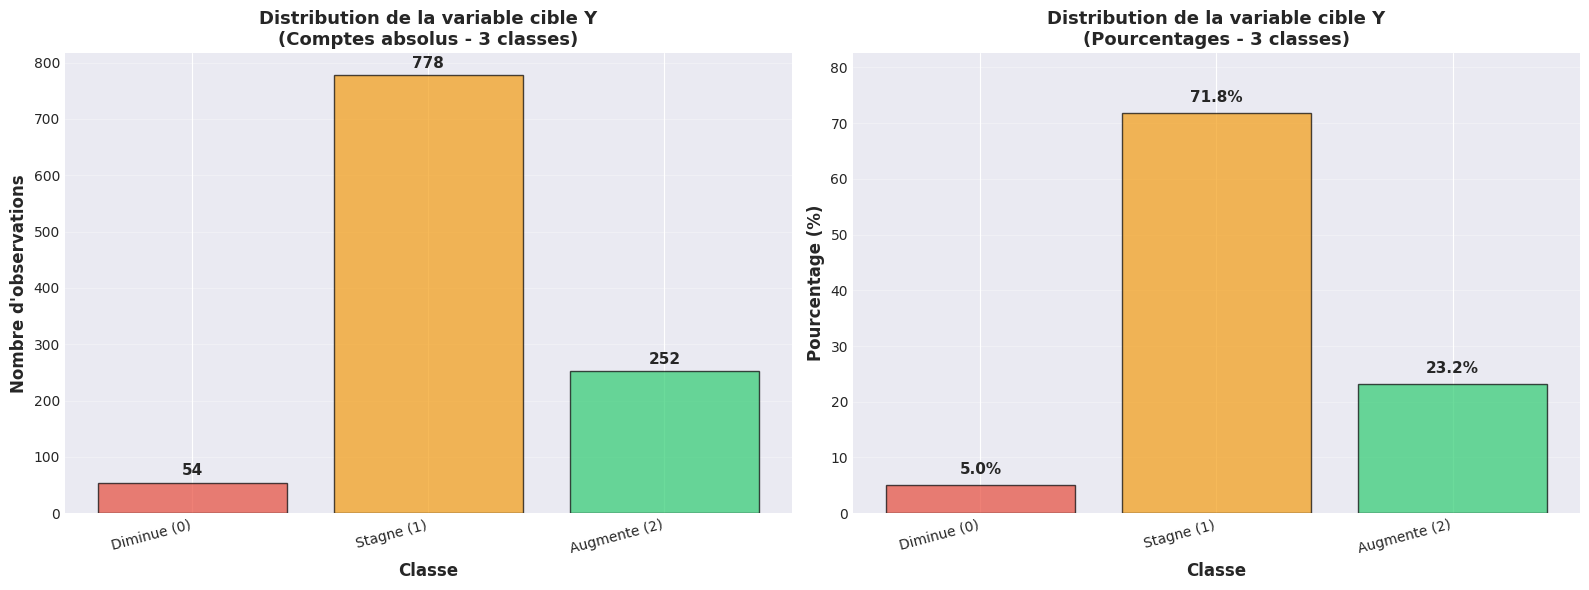


✓ Visualisation créée avec succès pour les 3 classes !


In [14]:
# Étape 6 : Visualisation de la distribution (3 CLASSES)

# Configuration du style
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : Bar plot avec comptes absolus
counts = df_clean['Y'].value_counts().sort_index()
colors = ['#e74c3c', '#f39c12', '#2ecc71']  # Rouge (Diminue), Orange (Stagne), Vert (Augmente)
labels_text = ['Diminue (0)', 'Stagne (1)', 'Augmente (2)']

axes[0].bar(counts.index, counts.values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Classe', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Nombre d\'observations', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution de la variable cible Y\n(Comptes absolus - 3 classes)', 
                   fontsize=13, fontweight='bold')
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(labels_text, rotation=15, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Ajout des valeurs au-dessus des barres
for i, v in enumerate(counts.values):
    axes[0].text(i, v + max(counts.values)*0.01, str(v), 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Graphique 2 : Pourcentages
pct = df_clean['Y'].value_counts(normalize=True).sort_index() * 100
axes[1].bar(pct.index, pct.values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Classe', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Pourcentage (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution de la variable cible Y\n(Pourcentages - 3 classes)', 
                  fontsize=13, fontweight='bold')
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(labels_text, rotation=15, ha='right')
axes[1].set_ylim([0, max(pct.values) * 1.15])
axes[1].grid(axis='y', alpha=0.3)

# Ajout des pourcentages au-dessus des barres
for i, v in enumerate(pct.values):
    axes[1].text(i, v + max(pct.values)*0.02, f'{v:.1f}%', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✓ Visualisation créée avec succès pour les 3 classes !")
print("="*80)

## Vérification et exploration supplémentaire

Quelques vérifications utiles avant de passer à la modélisation :

In [15]:
# Vérification : Afficher quelques exemples pour chaque pays
print("Exemples de données avec la variable cible Y :\n")

# Sélectionner quelques pays pour l'illustration
sample_locations = df_clean[location_col].unique()[:3]

for loc in sample_locations:
    print(f"\n{'='*60}")
    print(f"Pays/Région : {loc}")
    print('='*60)
    sample_data = df_clean[df_clean[location_col] == loc][[
        location_col, period_col, value_col, 'value_diff', 'Y', 'Y_label'
    ]].head(10)
    print(sample_data.to_string(index=False))
    print()

Exemples de données avec la variable cible Y :


Pays/Région : Albania
Country Name  Year       Value  value_diff  Y  Y_label
     Albania  2016 3415.349428  151.783142  2 Augmente
     Albania  2017 3561.038801  145.689373  2 Augmente
     Albania  2018 3619.240209   58.201408  2 Augmente
     Albania  2019 3732.947927  113.707717  2 Augmente
     Albania  2020 3946.051306  213.103380  2 Augmente


Pays/Région : Australia
Country Name  Year       Value  value_diff  Y  Y_label
   Australia  2013 3353.098308  -14.745113  0  Diminue
   Australia  2013 3353.098308    0.000000  1   Stagne
   Australia  2013 3353.098308    0.000000  1   Stagne
   Australia  2013 3353.098308    0.000000  1   Stagne
   Australia  2013 3353.098308    0.000000  1   Stagne
   Australia  2013 3353.098308    0.000000  1   Stagne
   Australia  2014 3361.027233    7.928924  2 Augmente
   Australia  2015 3379.711188   18.683955  2 Augmente
   Australia  2016 3403.269497   23.558309  2 Augmente
   Australia  2016 3403

Statistiques de la variable 'value_diff' :
count    1084.000000
mean       11.018564
std        30.264933
min      -129.763283
25%         0.000000
50%         0.000000
75%         0.000000
max       284.641669
Name: value_diff, dtype: float64


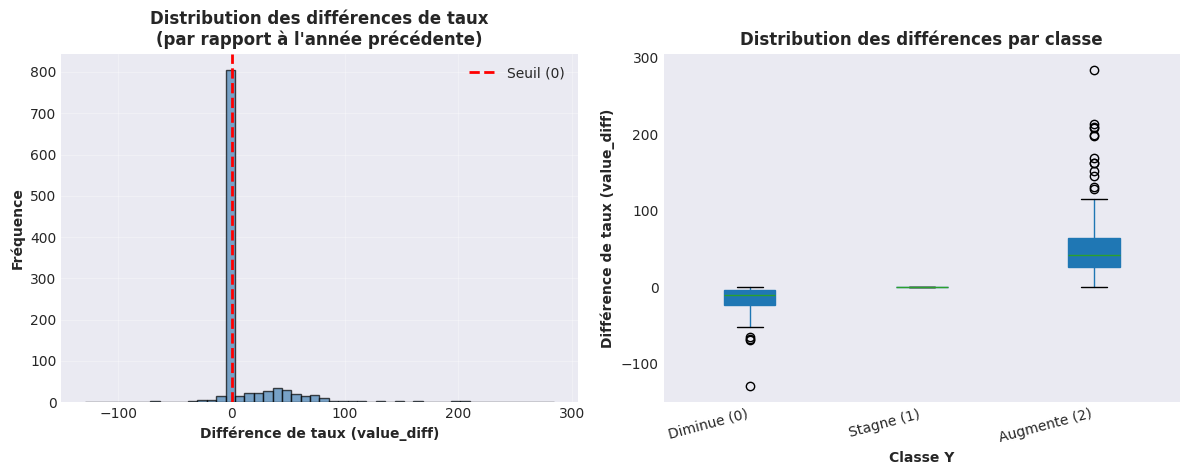

In [16]:
# Statistiques descriptives de la différence value_diff
print("Statistiques de la variable 'value_diff' :")
print(df_clean['value_diff'].describe())

# Distribution de value_diff
plt.figure(figsize=(12, 5))

# Histogramme
plt.subplot(1, 2, 1)
plt.hist(df_clean['value_diff'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Seuil (0)')
plt.xlabel('Différence de taux (value_diff)', fontweight='bold')
plt.ylabel('Fréquence', fontweight='bold')
plt.title('Distribution des différences de taux\n(par rapport à l\'année précédente)', 
          fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Boxplot pour les 3 classes
plt.subplot(1, 2, 2)
df_clean.boxplot(column='value_diff', by='Y', ax=plt.gca(), 
                 patch_artist=True, grid=False)
plt.suptitle('')  # Supprimer le titre auto-généré
plt.xlabel('Classe Y', fontweight='bold')
plt.ylabel('Différence de taux (value_diff)', fontweight='bold')
plt.title('Distribution des différences par classe', fontweight='bold')
plt.xticks([1, 2, 3], ['Diminue (0)', 'Stagne (1)', 'Augmente (2)'], rotation=15, ha='right')

plt.tight_layout()
plt.show()

## Sauvegarde des données préparées

Le DataFrame `df_clean` est maintenant prêt pour la modélisation de Machine Learning.

In [17]:
# Sauvegarde optionnelle des données préparées
# df_clean.to_csv('COPD_prepared_for_classification_multiclass.csv', index=False)
# print("✓ Données sauvegardées dans 'COPD_prepared_for_classification_multiclass.csv'")

# Résumé final
print("\n" + "="*80)
print("RÉSUMÉ DE LA PRÉPARATION DES DONNÉES - CLASSIFICATION MULTI-CLASSE")
print("="*80)
print(f"DataFrame original (df) : {len(df)} lignes")
print(f"DataFrame nettoyé (df_clean) : {len(df_clean)} lignes")
print(f"Nombre de pays/régions : {df_clean[location_col].nunique()}")
print(f"Période couverte : {df_clean[period_col].min()} - {df_clean[period_col].max()}")
print(f"\nVariable cible 'Y' (3 classes) :")
print(f"  - 0 (Diminue)  : {(df_clean['Y'] == 0).sum()} observations ({(df_clean['Y'] == 0).sum() / len(df_clean) * 100:.1f}%)")
print(f"  - 1 (Stagne)   : {(df_clean['Y'] == 1).sum()} observations ({(df_clean['Y'] == 1).sum() / len(df_clean) * 100:.1f}%)")
print(f"  - 2 (Augmente) : {(df_clean['Y'] == 2).sum()} observations ({(df_clean['Y'] == 2).sum() / len(df_clean) * 100:.1f}%)")
print("\n✓ Les données sont prêtes pour l'entraînement de modèles de classification multi-classe !")
print("="*80)


RÉSUMÉ DE LA PRÉPARATION DES DONNÉES - CLASSIFICATION MULTI-CLASSE
DataFrame original (df) : 1131 lignes
DataFrame nettoyé (df_clean) : 1084 lignes
Nombre de pays/régions : 44
Période couverte : 2010 - 2021

Variable cible 'Y' (3 classes) :
  - 0 (Diminue)  : 54 observations (5.0%)
  - 1 (Stagne)   : 778 observations (71.8%)
  - 2 (Augmente) : 252 observations (23.2%)

✓ Les données sont prêtes pour l'entraînement de modèles de classification multi-classe !


## Correction du déséquilibre des classes avec SMOTE

Le déséquilibre des classes peut causer des problèmes de performance, notamment un mauvais rappel pour la classe minoritaire. Nous allons utiliser **SMOTE** (Synthetic Minority Over-sampling Technique) pour générer des échantillons synthétiques de la classe minoritaire.

**Important** : SMOTE sera appliqué **uniquement sur l'ensemble d'entraînement** pour éviter la fuite de données (data leakage).

In [18]:
# Installation de la bibliothèque imbalanced-learn (si nécessaire)
# !pip install imbalanced-learn

# Import des bibliothèques pour SMOTE et classification multi-classe
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("✓ Bibliothèques importées avec succès pour la classification multi-classe !")
print("="*80)

✓ Bibliothèques importées avec succès pour la classification multi-classe !


In [19]:
# Préparation des données pour la modélisation

# Créer une copie propre du DataFrame
df_model = df_clean.copy()

print("⚠️ Création de features pour la modélisation...")

# Création de features numériques basées sur les données temporelles
df_model['value_lag1'] = df_model.groupby(location_col)[value_col].shift(1)
df_model['value_lag2'] = df_model.groupby(location_col)[value_col].shift(2)
df_model['rolling_mean_3'] = df_model.groupby(location_col)[value_col].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
df_model['rolling_std_3'] = df_model.groupby(location_col)[value_col].transform(
    lambda x: x.rolling(window=3, min_periods=1).std()
)
df_model['year_numeric'] = df_model[period_col]

# Encodage du pays (conversion de catégorique en numérique)
le_location = LabelEncoder()
df_model['location_encoded'] = le_location.fit_transform(df_model[location_col])

# Suppression des lignes avec NaN créées par les lags
df_model = df_model.dropna().reset_index(drop=True)

# Définition explicite des features numériques à utiliser
available_features = ['value_lag1', 'value_lag2', 'rolling_mean_3', 
                      'rolling_std_3', 'year_numeric', 'location_encoded']

print(f"✓ Features créées : {available_features}")

# Préparation de X et y - IMPORTANT : conversion explicite en valeurs numériques
X = df_model[available_features].copy()
y = df_model['Y'].copy()

# Vérification que toutes les colonnes sont bien numériques
print(f"\n📋 Vérification des types de données dans X :")
print(X.dtypes)

# Vérification qu'il n'y a pas de valeurs non-numériques
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
if len(non_numeric_cols) > 0:
    print(f"\n⚠️ ATTENTION : Colonnes non-numériques détectées : {non_numeric_cols}")
    print("Conversion en cours...")
    for col in non_numeric_cols:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    X = X.dropna()
    y = y.loc[X.index]
    print("✓ Conversion terminée")
else:
    print("✓ Toutes les colonnes sont numériques")

print(f"\n📊 Dimensions finales :")
print(f"  X : {X.shape}")
print(f"  y : {y.shape}")
print(f"\n📊 Distribution de y avant SMOTE :")
print(y.value_counts())
print(f"\nPourcentages :")
print(y.value_counts(normalize=True) * 100)

⚠️ Création de features pour la modélisation...
✓ Features créées : ['value_lag1', 'value_lag2', 'rolling_mean_3', 'rolling_std_3', 'year_numeric', 'location_encoded']

📋 Vérification des types de données dans X :
value_lag1          float64
value_lag2          float64
rolling_mean_3      float64
rolling_std_3       float64
year_numeric          int64
location_encoded      int64
dtype: object
✓ Toutes les colonnes sont numériques

📊 Dimensions finales :
  X : (454, 6)
  y : (454,)

📊 Distribution de y avant SMOTE :
Y
1    376
2     64
0     14
Name: count, dtype: int64

Pourcentages :
Y
1    82.819383
2    14.096916
0     3.083700
Name: proportion, dtype: float64


In [20]:
# Division des données en ensemble d'entraînement et de test
# Important : SMOTE sera appliqué UNIQUEMENT sur l'ensemble d'entraînement

# Conversion explicite en arrays NumPy pour éviter les problèmes
X_array = X.values.astype(np.float64)
y_array = y.values.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(
    X_array, y_array, 
    test_size=0.2, 
    random_state=42,
    stratify=y_array  # Stratification pour garder les proportions dans train/test
)

print("Distribution avant SMOTE (3 CLASSES) :")
print(f"\nEnsemble d'entraînement :")
print(f"  Total : {len(y_train)} observations")
print(f"  Classe 0 (Diminue)  : {(y_train == 0).sum()}")
print(f"  Classe 1 (Stagne)   : {(y_train == 1).sum()}")
print(f"  Classe 2 (Augmente) : {(y_train == 2).sum()}")
print(f"\n  Pourcentages :")
print(f"  Classe 0 : {(y_train == 0).sum() / len(y_train) * 100:.2f}%")
print(f"  Classe 1 : {(y_train == 1).sum() / len(y_train) * 100:.2f}%")
print(f"  Classe 2 : {(y_train == 2).sum() / len(y_train) * 100:.2f}%")

print(f"\nEnsemble de test (reste déséquilibré - conditions réelles) :")
print(f"  Total : {len(y_test)} observations")
print(f"  Classe 0 (Diminue)  : {(y_test == 0).sum()}")
print(f"  Classe 1 (Stagne)   : {(y_test == 1).sum()}")
print(f"  Classe 2 (Augmente) : {(y_test == 2).sum()}")
print(f"\n  Pourcentages :")
print(f"  Classe 0 : {(y_test == 0).sum() / len(y_test) * 100:.2f}%")
print(f"  Classe 1 : {(y_test == 1).sum() / len(y_test) * 100:.2f}%")
print(f"  Classe 2 : {(y_test == 2).sum() / len(y_test) * 100:.2f}%")

print(f"\n✓ Données converties en arrays NumPy")
print(f"  Type de X_train : {type(X_train)}, dtype : {X_train.dtype}")
print(f"  Type de y_train : {type(y_train)}, dtype : {y_train.dtype}")
print("="*80)

Distribution avant SMOTE (3 CLASSES) :

Ensemble d'entraînement :
  Total : 363 observations
  Classe 0 (Diminue)  : 11
  Classe 1 (Stagne)   : 301
  Classe 2 (Augmente) : 51

  Pourcentages :
  Classe 0 : 3.03%
  Classe 1 : 82.92%
  Classe 2 : 14.05%

Ensemble de test (reste déséquilibré - conditions réelles) :
  Total : 91 observations
  Classe 0 (Diminue)  : 3
  Classe 1 (Stagne)   : 75
  Classe 2 (Augmente) : 13

  Pourcentages :
  Classe 0 : 3.30%
  Classe 1 : 82.42%
  Classe 2 : 14.29%

✓ Données converties en arrays NumPy
  Type de X_train : <class 'numpy.ndarray'>, dtype : float64
  Type de y_train : <class 'numpy.ndarray'>, dtype : int32


In [21]:
# Création du preprocesseur (normalisation des features)
# Toutes les features sont numériques dans notre cas
# Important : on utilise 'passthrough' comme remainder pour éviter les problèmes

from sklearn.preprocessing import StandardScaler

# Utilisation d'un simple StandardScaler au lieu de ColumnTransformer
# car toutes nos features sont numériques et doivent être normalisées
preprocessor = StandardScaler()

print("✓ Preprocesseur créé (StandardScaler pour toutes les features)")
print(f"  Features à normaliser : {available_features}")
print(f"  Nombre de features : {len(available_features)}")

✓ Preprocesseur créé (StandardScaler pour toutes les features)
  Features à normaliser : ['value_lag1', 'value_lag2', 'rolling_mean_3', 'rolling_std_3', 'year_numeric', 'location_encoded']
  Nombre de features : 6


### Définition des modèles avec SMOTE intégré

Nous utilisons `imblearn.pipeline.Pipeline` qui applique SMOTE uniquement lors de l'entraînement (.fit), pas lors de la prédiction (.predict).

In [22]:
# Définition des 3 modèles pour CLASSIFICATION MULTI-CLASSE avec Pipeline imblearn
# Structure : Preprocessor -> SMOTE -> Classifier

print("="*80)
print("CONFIGURATION DES MODÈLES POUR CLASSIFICATION MULTI-CLASSE (3 CLASSES)")
print("="*80)

models_with_smote = {
    'Logistic Regression': ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(
            multi_class='multinomial',  # Important pour multi-classe
            solver='lbfgs',              # Solver adapté pour multinomial
            random_state=42, 
            max_iter=1000
        ))
    ]),
    
    'Random Forest': ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(
            random_state=42, 
            n_estimators=100
            # Random Forest gère nativement la multi-classe
        ))
    ]),
    
    'XGBoost': ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', XGBClassifier(
            objective='multi:softmax',  # Important pour multi-classe
            num_class=3,                # Nombre de classes
            random_state=42, 
            eval_metric='mlogloss'      # Métrique pour multi-classe
        ))
    ])
}

print("\n✓ Modèles créés avec SMOTE intégré pour 3 classes :")
for model_name in models_with_smote.keys():
    print(f"  - {model_name}")
    
print("\n⚠️ SMOTE sera appliqué UNIQUEMENT sur X_train lors du .fit()")
print("   L'ensemble de test reste dans son état déséquilibré d'origine.")
print("="*80)

CONFIGURATION DES MODÈLES POUR CLASSIFICATION MULTI-CLASSE (3 CLASSES)

✓ Modèles créés avec SMOTE intégré pour 3 classes :
  - Logistic Regression
  - Random Forest
  - XGBoost

⚠️ SMOTE sera appliqué UNIQUEMENT sur X_train lors du .fit()
   L'ensemble de test reste dans son état déséquilibré d'origine.


### Entraînement et Évaluation des Modèles avec SMOTE

In [23]:
# Dictionnaire pour stocker les résultats
results_with_smote = {}

# Boucle d'entraînement et d'évaluation (CLASSIFICATION MULTI-CLASSE)
print("="*80)
print("ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES - CLASSIFICATION MULTI-CLASSE (3 CLASSES)")
print("="*80)

# Labels des classes pour les rapports
class_labels = ['Diminue (0)', 'Stagne (1)', 'Augmente (2)']

for model_name, model_pipeline in models_with_smote.items():
    print(f"\n{'='*80}")
    print(f"🔄 Modèle : {model_name}")
    print('='*80)
    
    # Entraînement (SMOTE est appliqué automatiquement ici)
    print(f"⏳ Entraînement en cours...")
    model_pipeline.fit(X_train, y_train)
    print(f"✓ Entraînement terminé")
    
    # Prédictions sur l'ensemble de test (SMOTE n'est PAS appliqué ici)
    y_pred = model_pipeline.predict(X_test)
    
    # Calcul des métriques (weighted pour gérer le multi-classe)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Stockage des résultats
    results_with_smote[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_pred': y_pred
    }
    
    # Affichage des métriques globales
    print(f"\n📊 Métriques globales (weighted average) :")
    print(f"   Accuracy  : {accuracy:.4f}")
    print(f"   Precision : {precision:.4f}")
    print(f"   Recall    : {recall:.4f}")
    print(f"   F1-Score  : {f1:.4f}")
    
    # Rapport de classification détaillé pour les 3 classes
    print(f"\n📋 Rapport de Classification (3 classes) :")
    print(classification_report(y_test, y_pred, 
                                target_names=class_labels,
                                zero_division=0))

print(f"\n{'='*80}")
print("✓ Tous les modèles ont été entraînés et évalués sur 3 classes !")
print('='*80)

ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES - CLASSIFICATION MULTI-CLASSE (3 CLASSES)

🔄 Modèle : Logistic Regression
⏳ Entraînement en cours...
✓ Entraînement terminé
✓ Entraînement terminé

📊 Métriques globales (weighted average) :
   Accuracy  : 0.5934
   Precision : 0.8901
   Recall    : 0.5934
   F1-Score  : 0.6858

📋 Rapport de Classification (3 classes) :
              precision    recall  f1-score   support

 Diminue (0)       0.09      1.00      0.17         3
  Stagne (1)       0.98      0.57      0.72        75
Augmente (2)       0.57      0.62      0.59        13

    accuracy                           0.59        91
   macro avg       0.55      0.73      0.49        91
weighted avg       0.89      0.59      0.69        91


🔄 Modèle : Random Forest
⏳ Entraînement en cours...

📊 Métriques globales (weighted average) :
   Accuracy  : 0.5934
   Precision : 0.8901
   Recall    : 0.5934
   F1-Score  : 0.6858

📋 Rapport de Classification (3 classes) :
              precision    recal

/home/aladin/.gml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✓ Entraînement terminé

📊 Métriques globales (weighted average) :
   Accuracy  : 0.7363
   Precision : 0.7470
   Recall    : 0.7363
   F1-Score  : 0.7411

📋 Rapport de Classification (3 classes) :
              precision    recall  f1-score   support

 Diminue (0)       0.00      0.00      0.00         3
  Stagne (1)       0.86      0.84      0.85        75
Augmente (2)       0.25      0.31      0.28        13

    accuracy                           0.74        91
   macro avg       0.37      0.38      0.38        91
weighted avg       0.75      0.74      0.74        91


🔄 Modèle : XGBoost
⏳ Entraînement en cours...
✓ Entraînement terminé

📊 Métriques globales (weighted average) :
   Accuracy  : 0.7363
   Precision : 0.7532
   Recall    : 0.7363
   F1-Score  : 0.7445

📋 Rapport de Classification (3 classes) :
              precision    recall  f1-score   support

 Diminue (0)       0.00      0.00      0.00         3
  Stagne (1)       0.88      0.85      0.86        75
Augmente (2)   

### Matrices de Confusion

Les matrices de confusion permettent de visualiser les performances par classe, notamment pour identifier les erreurs de classification.

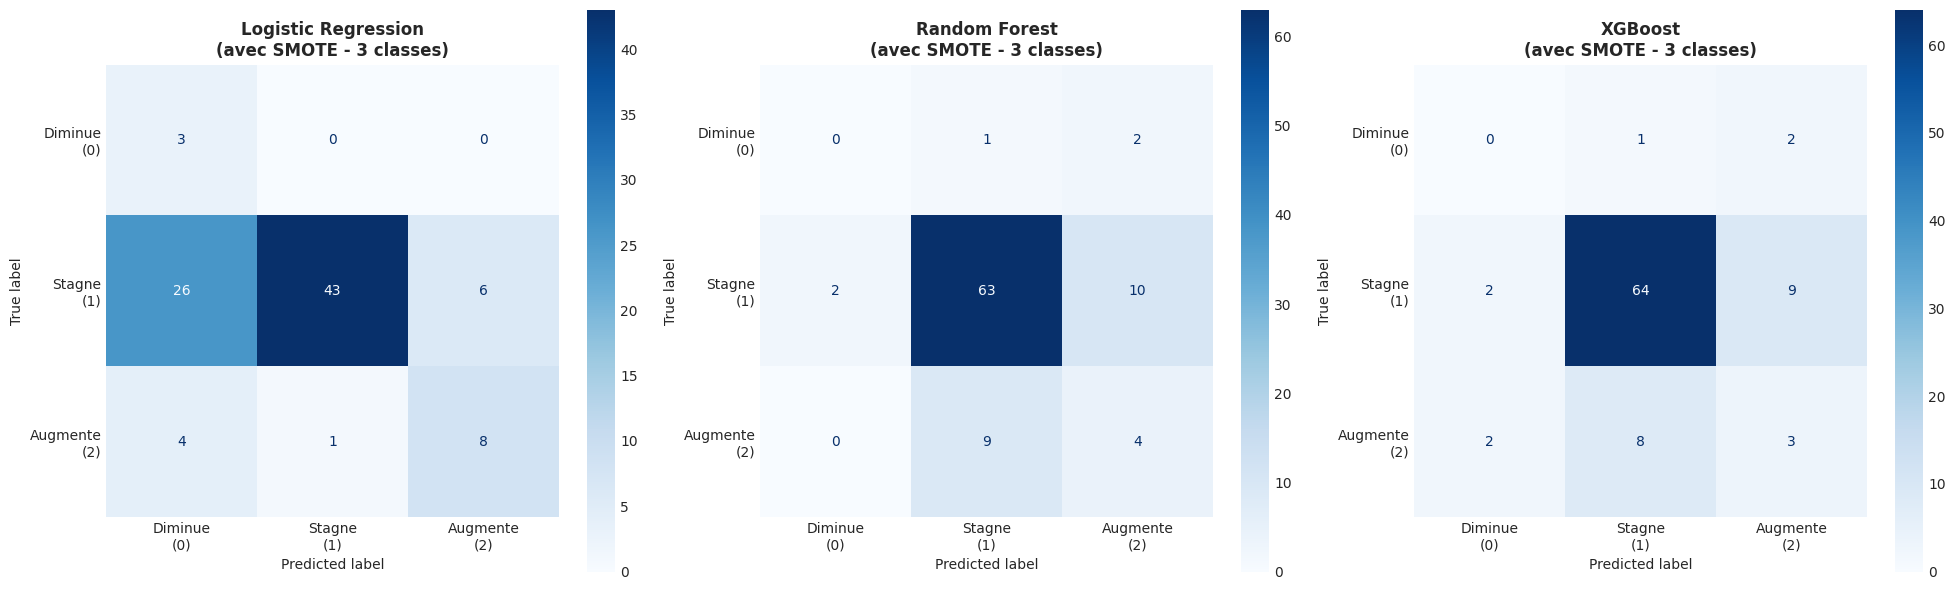

✓ Matrices de confusion affichées pour les 3 classes


In [24]:
# Affichage des matrices de confusion pour les 3 modèles (3 CLASSES)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Labels pour les 3 classes
display_labels = ['Diminue\n(0)', 'Stagne\n(1)', 'Augmente\n(2)']

for idx, (model_name, results) in enumerate(results_with_smote.items()):
    y_pred = results['y_pred']
    
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    
    # Affichage
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=display_labels
    )
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{model_name}\n(avec SMOTE - 3 classes)', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(False)

plt.tight_layout()
plt.show()

print("✓ Matrices de confusion affichées pour les 3 classes")
print("="*80)

### Comparaison des Performances par Classe

Analysons en détail les performances pour chaque classe (Diminue vs Augmente).

In [25]:
# Extraction des métriques par classe pour chaque modèle (3 CLASSES)

print("="*100)
print("ANALYSE DÉTAILLÉE DES PERFORMANCES PAR CLASSE (3 CLASSES)")
print("="*100)

metrics_by_class = {}
class_names = ['Diminue (0)', 'Stagne (1)', 'Augmente (2)']

for model_name, results in results_with_smote.items():
    y_pred = results['y_pred']
    
    print(f"\n{'='*100}")
    print(f"📊 {model_name}")
    print('='*100)
    
    # Calcul des métriques pour chaque classe
    report_dict = classification_report(
        y_test, y_pred, 
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    
    metrics_by_class[model_name] = report_dict
    
    # Affichage formaté
    print(f"\n{'Classe':<20} {'Precision':>12} {'Recall':>12} {'F1-Score':>12} {'Support':>12}")
    print("-" * 100)
    
    for class_name in class_names:
        metrics = report_dict[class_name]
        print(f"{class_name:<20} {metrics['precision']:>12.4f} {metrics['recall']:>12.4f} "
              f"{metrics['f1-score']:>12.4f} {int(metrics['support']):>12}")
    
    print("-" * 100)
    print(f"{'Accuracy':<20} {'':<12} {'':<12} {report_dict['accuracy']:>12.4f} "
          f"{int(report_dict['macro avg']['support']):>12}")
    print(f"{'Macro avg':<20} {report_dict['macro avg']['precision']:>12.4f} "
          f"{report_dict['macro avg']['recall']:>12.4f} "
          f"{report_dict['macro avg']['f1-score']:>12.4f} "
          f"{int(report_dict['macro avg']['support']):>12}")
    print(f"{'Weighted avg':<20} {report_dict['weighted avg']['precision']:>12.4f} "
          f"{report_dict['weighted avg']['recall']:>12.4f} "
          f"{report_dict['weighted avg']['f1-score']:>12.4f} "
          f"{int(report_dict['weighted avg']['support']):>12}")
    
    # Focus sur chaque classe
    print(f"\n🎯 Performance détaillée par classe :")
    for i, class_name in enumerate(class_names):
        class_metrics = report_dict[class_name]
        print(f"\n   Classe {i} - {class_name} :")
        print(f"      Precision : {class_metrics['precision']:.4f}")
        print(f"      Recall    : {class_metrics['recall']:.4f}")
        print(f"      F1-Score  : {class_metrics['f1-score']:.4f}")
        print(f"      Support   : {int(class_metrics['support'])} observations")

print(f"\n{'='*100}")
print("="*100)

ANALYSE DÉTAILLÉE DES PERFORMANCES PAR CLASSE (3 CLASSES)

📊 Logistic Regression

Classe                  Precision       Recall     F1-Score      Support
----------------------------------------------------------------------------------------------------
Diminue (0)                0.0909       1.0000       0.1667            3
Stagne (1)                 0.9773       0.5733       0.7227           75
Augmente (2)               0.5714       0.6154       0.5926           13
----------------------------------------------------------------------------------------------------
Accuracy                                             0.5934           91
Macro avg                  0.5465       0.7296       0.4940           91
Weighted avg               0.8901       0.5934       0.6858           91

🎯 Performance détaillée par classe :

   Classe 0 - Diminue (0) :
      Precision : 0.0909
      Recall    : 1.0000
      F1-Score  : 0.1667
      Support   : 3 observations

   Classe 1 - Stagne (1) :
  

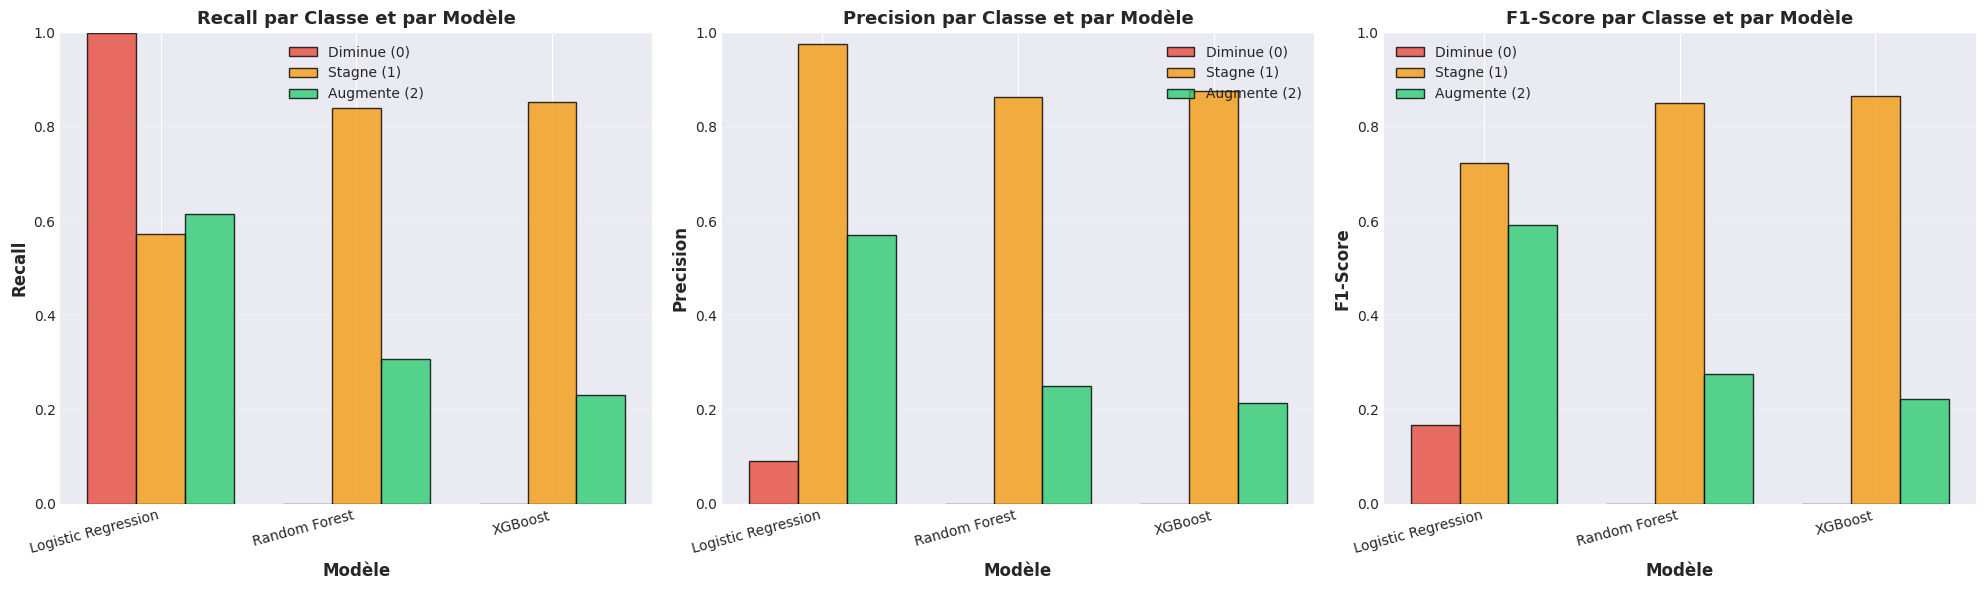

✓ Visualisations comparatives créées pour les 3 classes


In [26]:
# Visualisation comparative des performances pour les 3 CLASSES

# Extraction des métriques pour chaque classe
model_names = list(metrics_by_class.keys())
class_names_short = ['Diminue (0)', 'Stagne (1)', 'Augmente (2)']

# Préparation des données pour visualisation
recalls_by_class = {class_name: [] for class_name in class_names_short}
precisions_by_class = {class_name: [] for class_name in class_names_short}
f1_scores_by_class = {class_name: [] for class_name in class_names_short}

for model_name in model_names:
    for class_name in class_names_short:
        recalls_by_class[class_name].append(metrics_by_class[model_name][class_name]['recall'])
        precisions_by_class[class_name].append(metrics_by_class[model_name][class_name]['precision'])
        f1_scores_by_class[class_name].append(metrics_by_class[model_name][class_name]['f1-score'])

# Création de la visualisation
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Couleurs pour les 3 classes
colors_classes = ['#e74c3c', '#f39c12', '#2ecc71']  # Rouge, Orange, Vert

# Graphique 1 : Recall par classe
x = np.arange(len(model_names))
width = 0.25

for i, class_name in enumerate(class_names_short):
    axes[0].bar(x + i*width, recalls_by_class[class_name], width, 
                label=class_name, color=colors_classes[i], alpha=0.8, edgecolor='black')

axes[0].set_xlabel('Modèle', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Recall', fontsize=12, fontweight='bold')
axes[0].set_title('Recall par Classe et par Modèle', fontsize=13, fontweight='bold')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(model_names, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Graphique 2 : Precision par classe
for i, class_name in enumerate(class_names_short):
    axes[1].bar(x + i*width, precisions_by_class[class_name], width, 
                label=class_name, color=colors_classes[i], alpha=0.8, edgecolor='black')

axes[1].set_xlabel('Modèle', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision par Classe et par Modèle', fontsize=13, fontweight='bold')
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(model_names, rotation=15, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

# Graphique 3 : F1-Score par classe
for i, class_name in enumerate(class_names_short):
    axes[2].bar(x + i*width, f1_scores_by_class[class_name], width, 
                label=class_name, color=colors_classes[i], alpha=0.8, edgecolor='black')

axes[2].set_xlabel('Modèle', fontsize=12, fontweight='bold')
axes[2].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[2].set_title('F1-Score par Classe et par Modèle', fontsize=13, fontweight='bold')
axes[2].set_xticks(x + width)
axes[2].set_xticklabels(model_names, rotation=15, ha='right')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("✓ Visualisations comparatives créées pour les 3 classes")
print("="*80)

### Vérification de l'application correcte de SMOTE

Vérifions que SMOTE a bien été appliqué uniquement sur l'ensemble d'entraînement.

VÉRIFICATION DE L'APPLICATION DE SMOTE (3 CLASSES)

📊 Distribution AVANT SMOTE (ensemble d'entraînement original) :
  Classe 0 (Diminue  ) : 11 observations
  Classe 1 (Stagne   ) : 301 observations
  Classe 2 (Augmente ) : 51 observations

Pourcentages :
  Classe 0 (Diminue  ) : 3.03%
  Classe 1 (Stagne   ) : 82.92%
  Classe 2 (Augmente ) : 14.05%

📊 Distribution APRÈS SMOTE (ensemble d'entraînement rééchantillonné) :
  Classe 0 (Diminue  ) : 301 observations
  Classe 1 (Stagne   ) : 301 observations
  Classe 2 (Augmente ) : 301 observations

Pourcentages :
  Classe 0 (Diminue  ) : 33.33%
  Classe 1 (Stagne   ) : 33.33%
  Classe 2 (Augmente ) : 33.33%

📊 Distribution de l'ensemble de TEST (reste inchangée) :
  Classe 0 (Diminue  ) : 3 observations
  Classe 1 (Stagne   ) : 75 observations
  Classe 2 (Augmente ) : 13 observations

Pourcentages :
  Classe 0 (Diminue  ) : 3.30%
  Classe 1 (Stagne   ) : 82.42%
  Classe 2 (Augmente ) : 14.29%


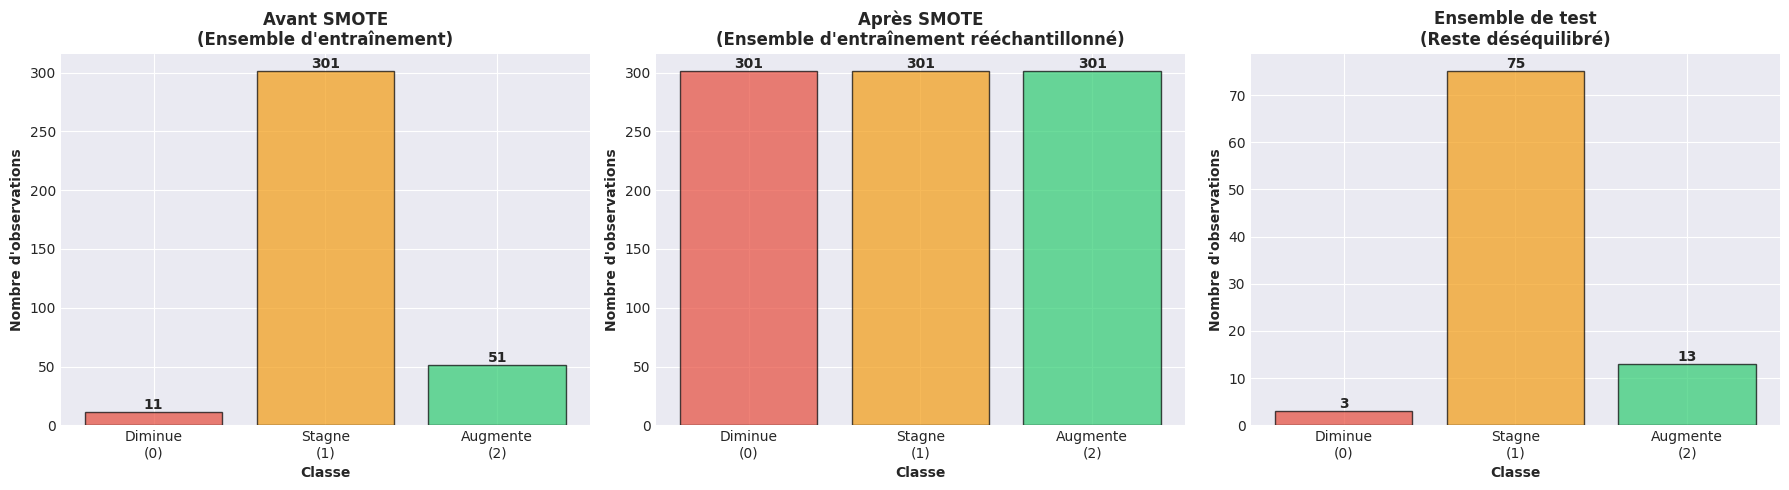


✓ SMOTE a correctement équilibré les 3 classes dans l'ensemble d'entraînement
✓ L'ensemble de test est resté dans son état déséquilibré d'origine
✓ Cela garantit une évaluation réaliste des performances


In [27]:
# Simulation de l'application de SMOTE pour voir l'effet (3 CLASSES)

# Application manuelle de SMOTE pour visualisation (à des fins pédagogiques uniquement)
smote_visualizer = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote_visualizer.fit_resample(X_train, y_train)

print("="*80)
print("VÉRIFICATION DE L'APPLICATION DE SMOTE (3 CLASSES)")
print("="*80)

# Fonction helper pour afficher la distribution d'un array NumPy
def print_distribution(y_array, title):
    unique, counts = np.unique(y_array, return_counts=True)
    print(f"\n{title}")
    class_names = {0: 'Diminue', 1: 'Stagne', 2: 'Augmente'}
    for val, count in zip(unique, counts):
        class_label = class_names.get(val, f'Classe {val}')
        print(f"  Classe {val} ({class_label:9s}) : {count} observations")
    print(f"\nPourcentages :")
    total = len(y_array)
    for val, count in zip(unique, counts):
        pct = (count / total) * 100
        class_label = class_names.get(val, f'Classe {val}')
        print(f"  Classe {val} ({class_label:9s}) : {pct:.2f}%")

# Distribution AVANT SMOTE
print_distribution(y_train, "📊 Distribution AVANT SMOTE (ensemble d'entraînement original) :")

# Distribution APRÈS SMOTE
print_distribution(y_train_resampled, "📊 Distribution APRÈS SMOTE (ensemble d'entraînement rééchantillonné) :")

# Distribution de TEST
print_distribution(y_test, "📊 Distribution de l'ensemble de TEST (reste inchangée) :")

# Visualisation comparative
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Couleurs pour les 3 classes
colors = ['#e74c3c', '#f39c12', '#2ecc71']  # Rouge, Orange, Vert

# Avant SMOTE
unique_before, counts_before = np.unique(y_train, return_counts=True)
axes[0].bar(unique_before, counts_before, color=[colors[i] for i in unique_before], 
            alpha=0.7, edgecolor='black')
axes[0].set_title('Avant SMOTE\n(Ensemble d\'entraînement)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Classe', fontweight='bold')
axes[0].set_ylabel('Nombre d\'observations', fontweight='bold')
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['Diminue\n(0)', 'Stagne\n(1)', 'Augmente\n(2)'])
for i, v in zip(unique_before, counts_before):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Après SMOTE
unique_after, counts_after = np.unique(y_train_resampled, return_counts=True)
axes[1].bar(unique_after, counts_after, color=[colors[i] for i in unique_after], 
            alpha=0.7, edgecolor='black')
axes[1].set_title('Après SMOTE\n(Ensemble d\'entraînement rééchantillonné)', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Classe', fontweight='bold')
axes[1].set_ylabel('Nombre d\'observations', fontweight='bold')
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(['Diminue\n(0)', 'Stagne\n(1)', 'Augmente\n(2)'])
for i, v in zip(unique_after, counts_after):
    axes[1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Ensemble de test
unique_test, counts_test = np.unique(y_test, return_counts=True)
axes[2].bar(unique_test, counts_test, color=[colors[i] for i in unique_test], 
            alpha=0.7, edgecolor='black')
axes[2].set_title('Ensemble de test\n(Reste déséquilibré)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Classe', fontweight='bold')
axes[2].set_ylabel('Nombre d\'observations', fontweight='bold')
axes[2].set_xticks([0, 1, 2])
axes[2].set_xticklabels(['Diminue\n(0)', 'Stagne\n(1)', 'Augmente\n(2)'])
for i, v in zip(unique_test, counts_test):
    axes[2].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ SMOTE a correctement équilibré les 3 classes dans l'ensemble d'entraînement")
print("✓ L'ensemble de test est resté dans son état déséquilibré d'origine")
print("✓ Cela garantit une évaluation réaliste des performances")
print("="*80)

### Résumé et Recommandations

Analysons les résultats obtenus avec SMOTE.

In [28]:
# Tableau récapitulatif des performances (CLASSIFICATION MULTI-CLASSE)

print("="*120)
print("TABLEAU RÉCAPITULATIF DES PERFORMANCES - CLASSIFICATION MULTI-CLASSE (3 CLASSES)")
print("="*120)

# Création d'un DataFrame pour le résumé
summary_data = []

for model_name, metrics in metrics_by_class.items():
    summary_data.append({
        'Modèle': model_name,
        'Accuracy': metrics['accuracy'],
        'Recall_Diminue': metrics['Diminue (0)']['recall'],
        'Recall_Stagne': metrics['Stagne (1)']['recall'],
        'Recall_Augmente': metrics['Augmente (2)']['recall'],
        'F1_Diminue': metrics['Diminue (0)']['f1-score'],
        'F1_Stagne': metrics['Stagne (1)']['f1-score'],
        'F1_Augmente': metrics['Augmente (2)']['f1-score'],
        'Macro_F1': metrics['macro avg']['f1-score'],
        'Weighted_F1': metrics['weighted avg']['f1-score']
    })

summary_df = pd.DataFrame(summary_data)

print("\n", summary_df.to_string(index=False))

# Identification du meilleur modèle selon différents critères
print("\n" + "="*120)
print("🏆 MEILLEURS MODÈLES PAR CRITÈRE :")
print("="*120)

# Meilleur Accuracy
best_acc_idx = summary_df['Accuracy'].idxmax()
print(f"\n1. Meilleure Accuracy : {summary_df.loc[best_acc_idx, 'Modèle']}")
print(f"   Accuracy = {summary_df.loc[best_acc_idx, 'Accuracy']:.4f}")

# Meilleur Macro F1 (moyenne non pondérée - important pour déséquilibre)
best_macro_f1_idx = summary_df['Macro_F1'].idxmax()
print(f"\n2. Meilleur Macro F1-Score : {summary_df.loc[best_macro_f1_idx, 'Modèle']}")
print(f"   Macro F1 = {summary_df.loc[best_macro_f1_idx, 'Macro_F1']:.4f}")

# Meilleur pour la classe "Stagne"
best_stagne_idx = summary_df['F1_Stagne'].idxmax()
print(f"\n3. Meilleur pour la classe 'Stagne' (F1) : {summary_df.loc[best_stagne_idx, 'Modèle']}")
print(f"   F1 Stagne = {summary_df.loc[best_stagne_idx, 'F1_Stagne']:.4f}")

# Meilleur pour la classe "Augmente"
best_augmente_idx = summary_df['F1_Augmente'].idxmax()
print(f"\n4. Meilleur pour la classe 'Augmente' (F1) : {summary_df.loc[best_augmente_idx, 'Modèle']}")
print(f"   F1 Augmente = {summary_df.loc[best_augmente_idx, 'F1_Augmente']:.4f}")

print("\n" + "="*120)
print("📝 OBSERVATIONS ET RECOMMANDATIONS :")
print("-" * 120)
print("1. ✓ Classification multi-classe (3 classes) : Diminue / Stagne / Augmente")
print("2. 🎯 La classe 'Stagne' peut avoir des performances variables selon sa fréquence")
print("3. 📊 Focus sur le Macro F1-Score pour une évaluation équilibrée des 3 classes")
print("4. ⚠️ Si une classe a un F1-Score très bas :")
print("   - Vérifier la distribution de cette classe")
print("   - Ajuster le seuil de stagnation (threshold)")
print("   - Utiliser des techniques de rééchantillonnage plus avancées")
print("5. 💡 Pour améliorer les performances :")
print("   - Ajuster le seuil threshold (essayer 0.001, 0.01, etc.)")
print("   - Utiliser des poids de classe (class_weight)")
print("   - Essayer d'autres techniques de rééchantillonnage (ADASYN, BorderlineSMOTE)")
print("-" * 120)
print("="*120)

TABLEAU RÉCAPITULATIF DES PERFORMANCES - CLASSIFICATION MULTI-CLASSE (3 CLASSES)

              Modèle  Accuracy  Recall_Diminue  Recall_Stagne  Recall_Augmente  F1_Diminue  F1_Stagne  F1_Augmente  Macro_F1  Weighted_F1
Logistic Regression  0.593407             1.0       0.573333         0.615385    0.166667   0.722689     0.592593  0.493983     0.685773
      Random Forest  0.736264             0.0       0.840000         0.307692    0.000000   0.851351     0.275862  0.375738     0.741072
            XGBoost  0.736264             0.0       0.853333         0.230769    0.000000   0.864865     0.222222  0.362362     0.744547

🏆 MEILLEURS MODÈLES PAR CRITÈRE :

1. Meilleure Accuracy : Random Forest
   Accuracy = 0.7363

2. Meilleur Macro F1-Score : Logistic Regression
   Macro F1 = 0.4940

3. Meilleur pour la classe 'Stagne' (F1) : XGBoost
   F1 Stagne = 0.8649

4. Meilleur pour la classe 'Augmente' (F1) : Logistic Regression
   F1 Augmente = 0.5926

📝 OBSERVATIONS ET RECOMMANDATIONS :
--

### Analyse de l'impact du seuil de stagnation

Voyons comment différents seuils affectent la distribution des classes.

ANALYSE DE L'IMPACT DU SEUIL DE STAGNATION

Distribution des classes selon différents seuils :

 Threshold  Diminue_count  Stagne_count  Augmente_count  Diminue_pct  Stagne_pct  Augmente_pct
     0.000             54           778             252     4.981550   71.771218     23.247232
     0.001             54           778             252     4.981550   71.771218     23.247232
     0.005             54           778             252     4.981550   71.771218     23.247232
     0.010             54           778             252     4.981550   71.771218     23.247232
     0.050             54           778             252     4.981550   71.771218     23.247232
     0.100             53           779             252     4.889299   71.863469     23.247232


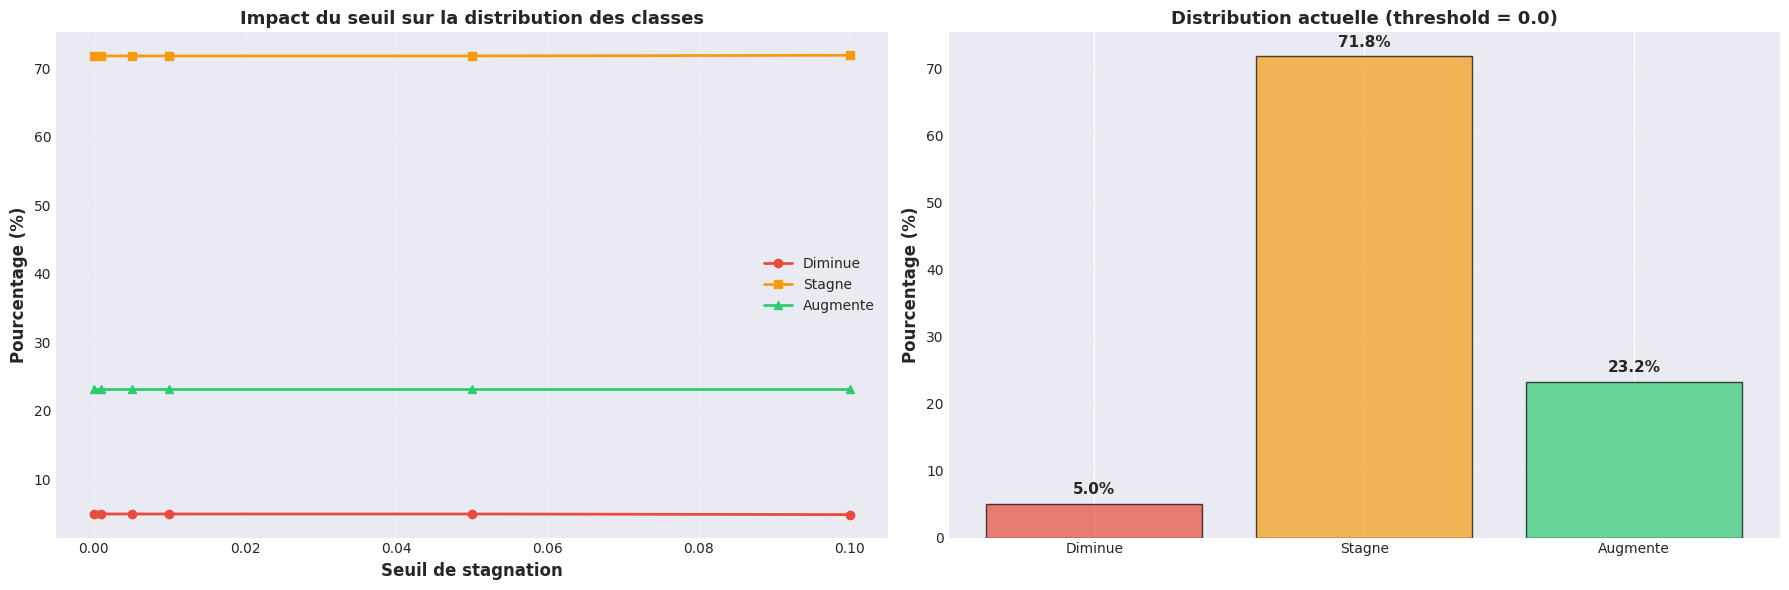


💡 RECOMMANDATIONS :
----------------------------------------------------------------------------------------------------
• Un seuil trop petit (0.0) : beaucoup de 'Stagne' si les valeurs sont proches de 0
• Un seuil trop grand (0.1) : peu de 'Stagne', mais risque de mal classifier
• Seuil recommandé : entre 0.001 et 0.01 selon la précision de vos données
• Ajustez le seuil en fonction de la distribution observée ci-dessus


In [29]:
# Analyse de l'impact de différents seuils sur la distribution des classes

print("="*100)
print("ANALYSE DE L'IMPACT DU SEUIL DE STAGNATION")
print("="*100)

# Test de différents seuils
thresholds_to_test = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1]

threshold_results = []

for threshold in thresholds_to_test:
    # Recréer Y avec ce seuil
    Y_temp = df_clean['value_diff'].apply(lambda x: classify_change(x, threshold))
    
    # Compter les classes
    counts = Y_temp.value_counts().sort_index()
    total = len(Y_temp)
    
    # Stocker les résultats
    result = {
        'Threshold': threshold,
        'Diminue_count': counts.get(0, 0),
        'Stagne_count': counts.get(1, 0),
        'Augmente_count': counts.get(2, 0),
        'Diminue_pct': (counts.get(0, 0) / total) * 100,
        'Stagne_pct': (counts.get(1, 0) / total) * 100,
        'Augmente_pct': (counts.get(2, 0) / total) * 100
    }
    threshold_results.append(result)

# Créer un DataFrame pour l'affichage
threshold_df = pd.DataFrame(threshold_results)

print("\nDistribution des classes selon différents seuils :\n")
print(threshold_df.to_string(index=False))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Graphique 1 : Évolution des pourcentages
axes[0].plot(threshold_df['Threshold'], threshold_df['Diminue_pct'], 
             marker='o', label='Diminue', color='#e74c3c', linewidth=2)
axes[0].plot(threshold_df['Threshold'], threshold_df['Stagne_pct'], 
             marker='s', label='Stagne', color='#f39c12', linewidth=2)
axes[0].plot(threshold_df['Threshold'], threshold_df['Augmente_pct'], 
             marker='^', label='Augmente', color='#2ecc71', linewidth=2)
axes[0].set_xlabel('Seuil de stagnation', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Pourcentage (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Impact du seuil sur la distribution des classes', 
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Graphique 2 : Barres empilées pour un seuil spécifique (threshold = 0.0)
current_threshold_idx = 0  # Index du seuil actuel (0.0)
current_data = threshold_df.iloc[current_threshold_idx]
classes = ['Diminue', 'Stagne', 'Augmente']
percentages = [current_data['Diminue_pct'], current_data['Stagne_pct'], current_data['Augmente_pct']]
colors = ['#e74c3c', '#f39c12', '#2ecc71']

axes[1].bar(classes, percentages, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Pourcentage (%)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Distribution actuelle (threshold = {current_data["Threshold"]})', 
                  fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Ajout des valeurs sur les barres
for i, (classe, pct) in enumerate(zip(classes, percentages)):
    axes[1].text(i, pct + 1, f'{pct:.1f}%', ha='center', va='bottom', 
                fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n" + "="*100)
print("💡 RECOMMANDATIONS :")
print("-" * 100)
print("• Un seuil trop petit (0.0) : beaucoup de 'Stagne' si les valeurs sont proches de 0")
print("• Un seuil trop grand (0.1) : peu de 'Stagne', mais risque de mal classifier")
print("• Seuil recommandé : entre 0.001 et 0.01 selon la précision de vos données")
print("• Ajustez le seuil en fonction de la distribution observée ci-dessus")
print("="*100)

### Guide : Comment choisir le bon seuil de stagnation

**Important** : Pour tester un nouveau seuil, vous devez :
1. Modifier la valeur de `threshold` dans la cellule "Création de la variable cible Y"
2. Ré-exécuter **toutes les cellules** depuis cette étape jusqu'à la fin
3. Comparer les performances des modèles

GUIDE : CHOISIR LE SEUIL OPTIMAL DE STAGNATION

📊 ANALYSE DE LA DISTRIBUTION DE value_diff :

count    1084.000000
mean       11.018564
std        30.264933
min      -129.763283
25%         0.000000
50%         0.000000
75%         0.000000
max       284.641669
Name: value_diff, dtype: float64

Percentiles de value_diff :
   1ème percentile (valeur absolue) : 0.000000
   5ème percentile (valeur absolue) : 0.000000
  10ème percentile (valeur absolue) : 0.000000
  25ème percentile (valeur absolue) : 0.000000
  50ème percentile (valeur absolue) : 0.000000
  75ème percentile (valeur absolue) : 6.657629
  90ème percentile (valeur absolue) : 48.153425
  95ème percentile (valeur absolue) : 71.019123
  99ème percentile (valeur absolue) : 133.193573

💡 RECOMMANDATIONS POUR CHOISIR LE SEUIL :

1. 📍 Seuil conservateur (peu de 'Stagne') :
   threshold = 0.000000  (5ème percentile)
   → Seulement ~10% des observations seraient 'Stagne'

2. 📍 Seuil modéré (équilibré) :
   threshold = 0.000000  (10èm

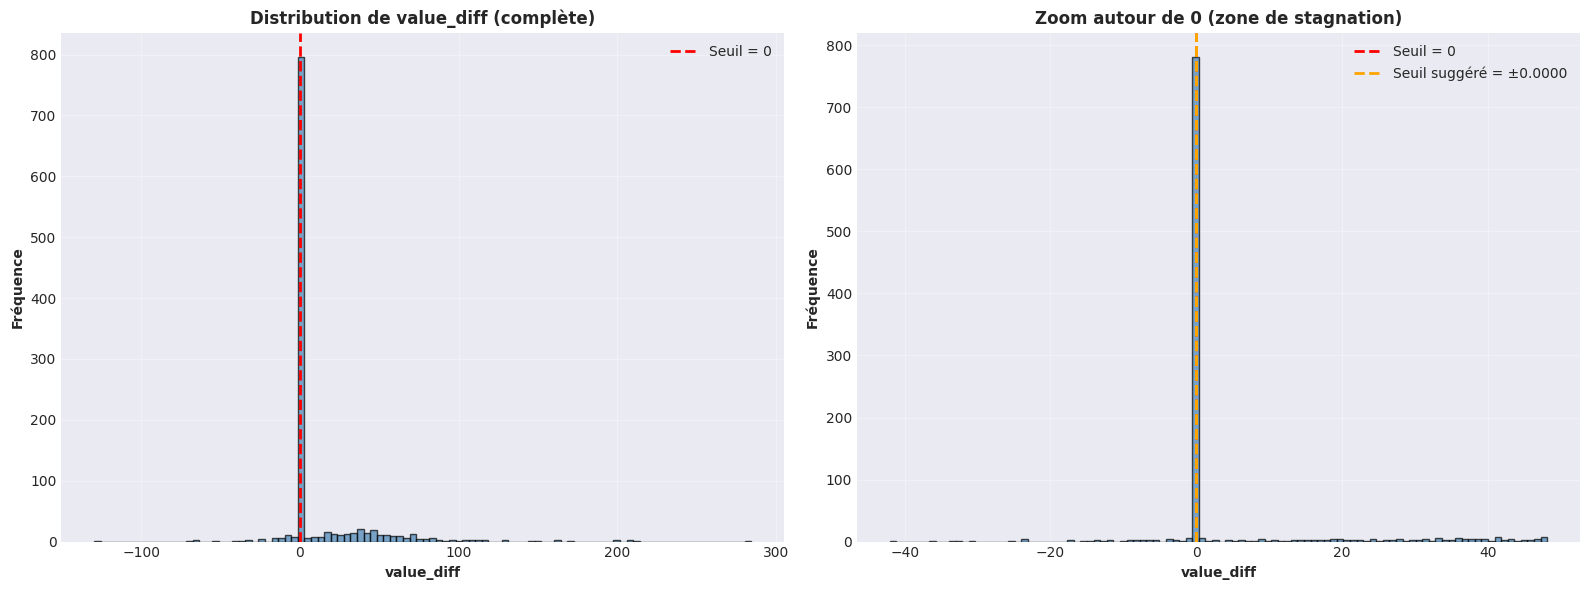


✓ Analyse terminée - Vous pouvez maintenant choisir votre seuil optimal !


In [30]:
# Guide pratique pour choisir le seuil optimal

print("="*100)
print("GUIDE : CHOISIR LE SEUIL OPTIMAL DE STAGNATION")
print("="*100)

# Analyse de la distribution de value_diff
print("\n📊 ANALYSE DE LA DISTRIBUTION DE value_diff :\n")
print(df_clean['value_diff'].describe())

# Calcul de quelques percentiles utiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("\nPercentiles de value_diff :")
for p in percentiles:
    val = np.percentile(df_clean['value_diff'].abs(), p)
    print(f"  {p:2d}ème percentile (valeur absolue) : {val:.6f}")

# Recommandations
print("\n" + "="*100)
print("💡 RECOMMANDATIONS POUR CHOISIR LE SEUIL :")
print("="*100)

# Calcul de suggestions
p5_abs = np.percentile(df_clean['value_diff'].abs(), 5)
p10_abs = np.percentile(df_clean['value_diff'].abs(), 10)
p25_abs = np.percentile(df_clean['value_diff'].abs(), 25)

print(f"\n1. 📍 Seuil conservateur (peu de 'Stagne') :")
print(f"   threshold = {p5_abs:.6f}  (5ème percentile)")
print(f"   → Seulement ~10% des observations seraient 'Stagne'")

print(f"\n2. 📍 Seuil modéré (équilibré) :")
print(f"   threshold = {p10_abs:.6f}  (10ème percentile)")
print(f"   → Environ ~20% des observations seraient 'Stagne'")

print(f"\n3. 📍 Seuil large (plus de 'Stagne') :")
print(f"   threshold = {p25_abs:.6f}  (25ème percentile)")
print(f"   → Environ ~50% des observations seraient 'Stagne'")

print(f"\n4. 📍 Seuil strict (très peu de 'Stagne') :")
print(f"   threshold = 0.0")
print(f"   → Uniquement les valeurs exactement égales à 0 sont 'Stagne'")

print("\n" + "="*100)
print("🔄 POUR TESTER UN NOUVEAU SEUIL :")
print("="*100)
print("""
1. Retournez à la cellule 'Création de la variable cible Y'
2. Modifiez la ligne : threshold = 0.0  
   Exemple : threshold = 0.005  # Votre nouveau seuil
3. Ré-exécutez TOUTES les cellules à partir de cette cellule
4. Comparez les résultats (distribution, performances des modèles)
5. Choisissez le seuil qui donne les meilleurs résultats pour votre cas d'usage
""")
print("="*100)

# Visualisation de la distribution de value_diff autour de 0
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogramme complet
axes[0].hist(df_clean['value_diff'], bins=100, color='steelblue', 
             alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Seuil = 0')
axes[0].set_xlabel('value_diff', fontweight='bold')
axes[0].set_ylabel('Fréquence', fontweight='bold')
axes[0].set_title('Distribution de value_diff (complète)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Zoom autour de 0 (pour mieux voir la zone de stagnation)
zoom_range = np.percentile(df_clean['value_diff'].abs(), 90)
value_diff_zoom = df_clean['value_diff'][(df_clean['value_diff'] >= -zoom_range) & 
                                          (df_clean['value_diff'] <= zoom_range)]
axes[1].hist(value_diff_zoom, bins=100, color='steelblue', 
             alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Seuil = 0')
axes[1].axvline(x=p10_abs, color='orange', linestyle='--', linewidth=2, 
                label=f'Seuil suggéré = ±{p10_abs:.4f}')
axes[1].axvline(x=-p10_abs, color='orange', linestyle='--', linewidth=2)
axes[1].set_xlabel('value_diff', fontweight='bold')
axes[1].set_ylabel('Fréquence', fontweight='bold')
axes[1].set_title('Zoom autour de 0 (zone de stagnation)', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Analyse terminée - Vous pouvez maintenant choisir votre seuil optimal !")
print("="*100)

## 📋 Résumé de la Classification Multi-Classe

Votre notebook est maintenant configuré pour la **classification à 3 classes** :
- **Classe 0 : Diminue** - Le taux de BPCO diminue par rapport à l'année précédente
- **Classe 1 : Stagne** - Le taux de BPCO reste stable (variation dans l'intervalle du seuil)
- **Classe 2 : Augmente** - Le taux de BPCO augmente par rapport à l'année précédente

### Points clés :
1. ✅ Les modèles sont configurés pour la multi-classe (LogisticRegression avec `multi_class='multinomial'`, XGBoost avec `objective='multi:softmax'`)
2. ✅ SMOTE est appliqué pour équilibrer les 3 classes
3. ✅ Les rapports de classification et matrices de confusion affichent les 3 classes
4. ✅ Vous pouvez ajuster le seuil de stagnation selon vos besoins

COMPARAISON : CLASSIFICATION BINAIRE vs MULTI-CLASSE

📊 CLASSIFICATION BINAIRE (2 classes) :
Y_binary
0    832
1    252
Name: count, dtype: int64

Pourcentages :
Y_binary
0    76.752768
1    23.247232
Name: proportion, dtype: float64

----------------------------------------------------------------------------------------------------

📊 CLASSIFICATION MULTI-CLASSE (3 classes) :
Y
0     54
1    778
2    252
Name: count, dtype: int64

Pourcentages :
Y
0     4.981550
1    71.771218
2    23.247232
Name: proportion, dtype: float64


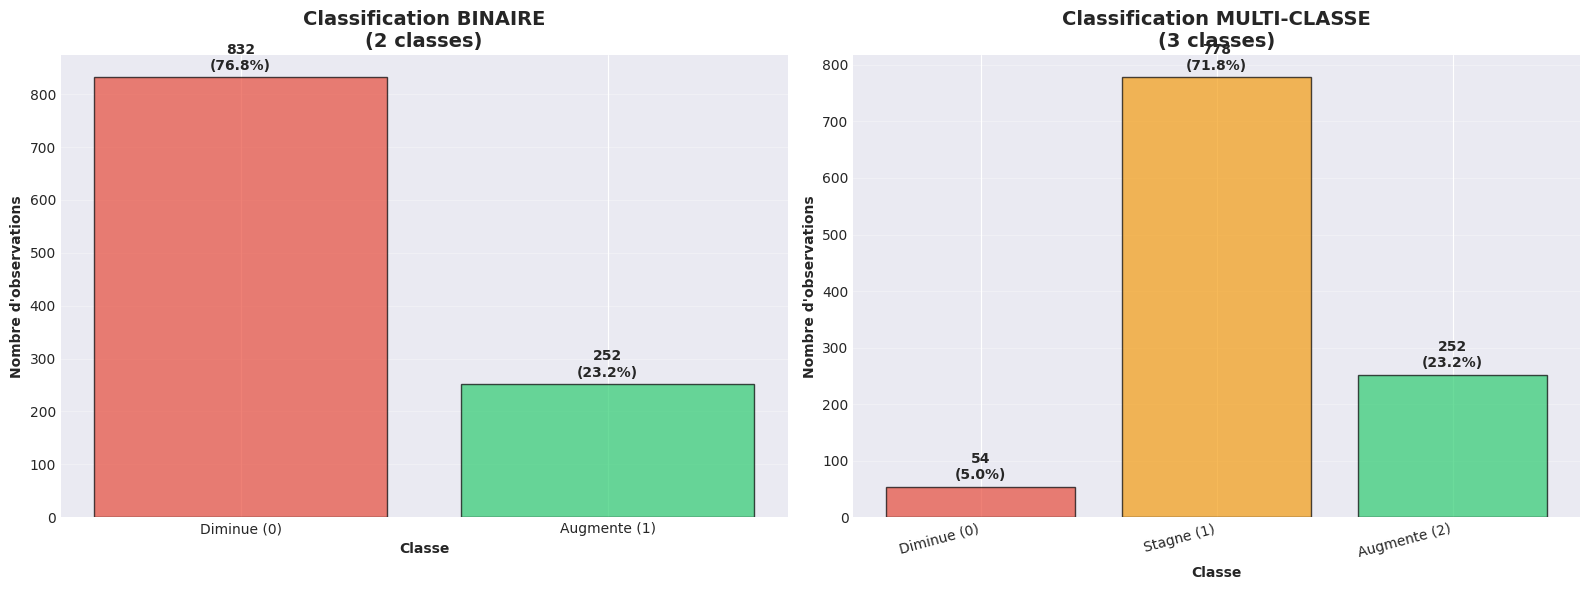


✅ AVANTAGES DE LA CLASSIFICATION MULTI-CLASSE :
1. ✓ Séparation des cas de stagnation (value_diff ≈ 0)
2. ✓ Analyse plus fine des tendances
3. ✓ Meilleure compréhension des cas limites
4. ✓ Évite la pollution de la classe 'Diminue' par les cas de stagnation

⚠️ ATTENTION :
- La classe 'Stagne' peut être peu représentée selon le seuil choisi
- Performances potentiellement plus faibles que le binaire si déséquilibre important
- Nécessite plus de données pour un entraînement robuste


In [31]:
# Visualisation finale : Comparaison Classification Binaire vs Multi-Classe

print("="*100)
print("COMPARAISON : CLASSIFICATION BINAIRE vs MULTI-CLASSE")
print("="*100)

# Simulation de la classification binaire pour comparaison
df_clean['Y_binary'] = (df_clean['value_diff'] > 0).astype(int)

print("\n📊 CLASSIFICATION BINAIRE (2 classes) :")
print(df_clean['Y_binary'].value_counts().sort_index())
print("\nPourcentages :")
print(df_clean['Y_binary'].value_counts(normalize=True).sort_index() * 100)

print("\n" + "-"*100)

print("\n📊 CLASSIFICATION MULTI-CLASSE (3 classes) :")
print(df_clean['Y'].value_counts().sort_index())
print("\nPourcentages :")
print(df_clean['Y'].value_counts(normalize=True).sort_index() * 100)

# Visualisation côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Classification binaire
binary_counts = df_clean['Y_binary'].value_counts().sort_index()
axes[0].bar([0, 1], binary_counts.values, 
            color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0].set_title('Classification BINAIRE\n(2 classes)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe', fontweight='bold')
axes[0].set_ylabel('Nombre d\'observations', fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Diminue (0)', 'Augmente (1)'])
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(binary_counts.values):
    pct = (v / binary_counts.sum()) * 100
    axes[0].text(i, v + binary_counts.max()*0.01, f'{v}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# Classification multi-classe
multi_counts = df_clean['Y'].value_counts().sort_index()
axes[1].bar([0, 1, 2], multi_counts.values, 
            color=['#e74c3c', '#f39c12', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[1].set_title('Classification MULTI-CLASSE\n(3 classes)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Classe', fontweight='bold')
axes[1].set_ylabel('Nombre d\'observations', fontweight='bold')
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(['Diminue (0)', 'Stagne (1)', 'Augmente (2)'], rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(multi_counts.values):
    pct = (v / multi_counts.sum()) * 100
    axes[1].text(i, v + multi_counts.max()*0.01, f'{v}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*100)
print("✅ AVANTAGES DE LA CLASSIFICATION MULTI-CLASSE :")
print("="*100)
print("1. ✓ Séparation des cas de stagnation (value_diff ≈ 0)")
print("2. ✓ Analyse plus fine des tendances")
print("3. ✓ Meilleure compréhension des cas limites")
print("4. ✓ Évite la pollution de la classe 'Diminue' par les cas de stagnation")
print("\n⚠️ ATTENTION :")
print("- La classe 'Stagne' peut être peu représentée selon le seuil choisi")
print("- Performances potentiellement plus faibles que le binaire si déséquilibre important")
print("- Nécessite plus de données pour un entraînement robuste")
print("="*100)

### (Optionnel) Ajustements supplémentaires

Si les résultats avec SMOTE standard ne sont pas satisfaisants, vous pouvez essayer ces variantes :

In [32]:
# OPTION 1 : SMOTE avec un ratio de rééchantillonnage personnalisé
# Par défaut, SMOTE équilibre complètement (50-50)
# On peut spécifier un ratio différent, ex: 0.7 (70% de la classe majoritaire)

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

print("="*80)
print("OPTIONS D'AJUSTEMENT SUPPLÉMENTAIRES")
print("="*80)

print("\n1️⃣ SMOTE avec ratio personnalisé :")
print("   smote = SMOTE(sampling_strategy=0.7, random_state=42)")
print("   # 70% au lieu de 100% (équilibre partiel)")

print("\n2️⃣ ADASYN (Adaptive Synthetic Sampling) :")
print("   adasyn = ADASYN(random_state=42)")
print("   # Génère plus d'échantillons dans les zones difficiles")

print("\n3️⃣ BorderlineSMOTE :")
print("   borderline_smote = BorderlineSMOTE(random_state=42)")
print("   # Se concentre sur les échantillons proches de la frontière de décision")

print("\n4️⃣ Combinaison SMOTE + class_weight :")
print("   Pour la Régression Logistique, ajoutez class_weight='balanced'")
print("   LogisticRegression(class_weight='balanced', random_state=42)")

print("\n5️⃣ Ajustement du seuil de décision :")
print("   Au lieu de 0.5, utilisez un seuil plus bas (ex: 0.3) pour favoriser")
print("   la classe minoritaire")

print("\n" + "="*80)
print("💡 CONSEIL : Testez ces options si le Recall de 'Augmente (1)' < 0.60")
print("="*80)

OPTIONS D'AJUSTEMENT SUPPLÉMENTAIRES

1️⃣ SMOTE avec ratio personnalisé :
   smote = SMOTE(sampling_strategy=0.7, random_state=42)
   # 70% au lieu de 100% (équilibre partiel)

2️⃣ ADASYN (Adaptive Synthetic Sampling) :
   adasyn = ADASYN(random_state=42)
   # Génère plus d'échantillons dans les zones difficiles

3️⃣ BorderlineSMOTE :
   borderline_smote = BorderlineSMOTE(random_state=42)
   # Se concentre sur les échantillons proches de la frontière de décision

4️⃣ Combinaison SMOTE + class_weight :
   Pour la Régression Logistique, ajoutez class_weight='balanced'
   LogisticRegression(class_weight='balanced', random_state=42)

5️⃣ Ajustement du seuil de décision :
   Au lieu de 0.5, utilisez un seuil plus bas (ex: 0.3) pour favoriser
   la classe minoritaire

💡 CONSEIL : Testez ces options si le Recall de 'Augmente (1)' < 0.60


In [33]:
# Exemple d'implémentation avec ADASYN (si SMOTE standard n'est pas satisfaisant)

# Décommenter et exécuter ce code pour tester ADASYN
"""
print("\\nTest avec ADASYN...")

model_adasyn = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

model_adasyn.fit(X_train, y_train)
y_pred_adasyn = model_adasyn.predict(X_test)

print("\\nRésultats avec ADASYN :")
print(classification_report(y_test, y_pred_adasyn, 
                           target_names=['Diminue (0)', 'Augmente (1)'],
                           zero_division=0))
"""

print("✓ Code d'exemple prêt (décommenter pour tester ADASYN)")

✓ Code d'exemple prêt (décommenter pour tester ADASYN)
